# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [ ]:
from bs4 import BeautifulSoup
import requests
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd


In [11]:
# URL de la página
url = "https://companies-market-cap-copy.vercel.app/index.html"

# Descargar el HTML
response = requests.get(url)

# Verificar si la solicitud fue exitosa
if response.status_code != 200:
    raise Exception(f"Error al acceder a la página: {response.status_code}")

# Guardar el contenido HTML
html_content = response.text

print(html_content[:500])


<!DOCTYPE html>
<html lang="en-US">
<head>
<title>Tesla (TSLA) - Revenue</title>
<meta charset="utf-8"/>
<link rel="shortcut icon" href="https://companiesmarketcap.com/favicon.ico" type="image/x-icon">
<link rel="apple-touch-icon" sizes="57x57" href="/img/icons/apple-icon-57x57.png">
<link rel="apple-touch-icon" sizes="60x60" href="/img/icons/apple-icon-60x60.png">
<link rel="apple-touch-icon" sizes="72x72" href="/img/icons/apple-icon-72x72.png">
<link rel="apple-touch-icon" sizes="76x76" href=


In [12]:
#Analizar el HTML
soup = BeautifulSoup(html_content, "html.parser")
print (soup)


<!DOCTYPE html>

<html lang="en-US">
<head>
<title>Tesla (TSLA) - Revenue</title>
<meta charset="utf-8"/>
<link href="https://companiesmarketcap.com/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<link href="/img/icons/apple-icon-57x57.png" rel="apple-touch-icon" sizes="57x57"/>
<link href="/img/icons/apple-icon-60x60.png" rel="apple-touch-icon" sizes="60x60"/>
<link href="/img/icons/apple-icon-72x72.png" rel="apple-touch-icon" sizes="72x72"/>
<link href="/img/icons/apple-icon-76x76.png" rel="apple-touch-icon" sizes="76x76"/>
<link href="/img/icons/apple-icon-114x114.png" rel="apple-touch-icon" sizes="114x114"/>
<link href="/img/icons/apple-icon-120x120.png" rel="apple-touch-icon" sizes="120x120"/>
<link href="/img/icons/apple-icon-144x144.png" rel="apple-touch-icon" sizes="144x144"/>
<link href="/img/icons/apple-icon-152x152.png" rel="apple-touch-icon" sizes="152x152"/>
<link href="/img/icons/apple-icon-180x180.png" rel="apple-touch-icon" sizes="180x180"/>
<link href="/img/ic

In [13]:
#Tabla de Ingresos extracción

table = soup.find("table")  
table

rows = table.find_all("tr")

# Procesar datos de la tabla
data = []
for row in rows[1:]:  # Saltar la fila de encabezado
    cols = row.find_all("td")
    fecha = cols[0].text.strip()
    ingresos = cols[1].text.strip()
    data.append([fecha, ingresos])

data

[['2024', '$97.15 B'],
 ['2023', '$96.77 B'],
 ['2022', '$81.46 B'],
 ['2021', '$53.82 B'],
 ['2020', '$31.53 B'],
 ['2019', '$24.57 B'],
 ['2018', '$21.46 B'],
 ['2017', '$11.75 B'],
 ['2016', '$7.00 B'],
 ['2015', '$4.04 B'],
 ['2014', '$3.19 B'],
 ['2013', '$2.01 B'],
 ['2012', '$0.41 B'],
 ['2011', '$0.20 B'],
 ['2010', '$0.11 B'],
 ['2009', '$0.11 B']]

In [14]:
# Convertir en DataFrame
df = pd.DataFrame(data, columns=["Date", "Revenue"])
df = df.sort_values("Date")
df


,Date,Revenue
15,2009,$0.11 B
14,2010,$0.11 B
13,2011,$0.20 B
12,2012,$0.41 B
11,2013,$2.01 B
10,2014,$3.19 B
9,2015,$4.04 B
8,2016,$7.00 B
7,2017,$11.75 B
6,2018,$21.46 B


In [15]:
#Quitar "b" y "$"

def convert_revenue(value):
    if "B" in value:
        edit_value = float(value.replace("B", "").replace("$", "").replace(",", ""))
        return edit_value

df["Revenue"] = df["Revenue"].apply(convert_revenue)
df["Revenue"]

15     0.11
14     0.11
13     0.20
12     0.41
11     2.01
10     3.19
9      4.04
8      7.00
7     11.75
6     21.46
5     24.57
4     31.53
3     53.82
2     81.46
1     96.77
0     97.15
Name: Revenue, dtype: float64

In [16]:
# Conectar SQLite, guardar datos y crear tabla
conn = sqlite3.connect("tesla_revenues.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS revenue (
    date TEXT,
    revenue REAL
)
""")

## Insertar datos en BD
for index, row in df.iterrows():
    cursor.execute("INSERT INTO revenue (date, revenue) VALUES (?, ?)", (row["Date"], row["Revenue"]))

conn.commit()
conn.close()

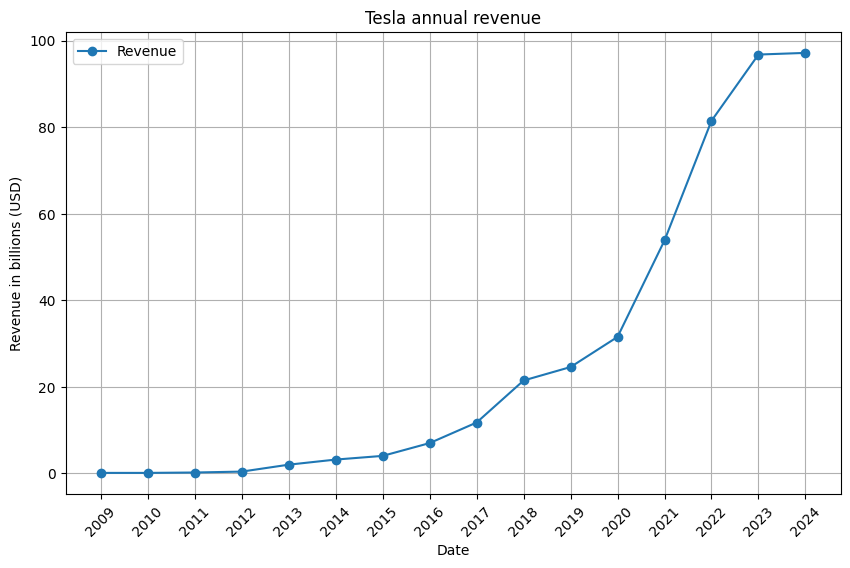

In [ ]:
# Visualizar los datos
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Revenue"], marker='o', label="Revenue")
plt.title("Tesla annual revenue")
plt.xlabel("Date")
plt.ylabel("Revenue in billions (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

#mostrar gráfico
plt.savefig("revenue_plot.png")
plt.show()




In [18]:
# Ejercicio extra

data = [
    {
        "Año": row.find_all("td")[0].text.strip(),
        "Ganancias": row.find_all("td")[1].text.strip()
    }
    for row in soup.find("table", {"class": "table"}).find_all("tr")[1:]
]

# Convertir a DataFrame
df = pd.DataFrame(data)

# Función para limpiar valores monetarios
def parse_earnings(value):
    value = value.replace("$", "").replace(",", "").strip()
    return (
        float(value.replace("Billion", "")) * 1e9 if "Billion" in value else
        float(value.replace("Million", "")) * 1e6 if "Million" in value else
        float(value.replace("B", "")) * 1e9 if "B" in value else
        float(value.replace("M", "")) * 1e6 if "M" in value else
        float(value)
    )

# Aplicar funciones de limpieza
df["Año"] = df["Año"].str.extract("(\d+)").astype(float).astype("Int64")
df["Ganancias"] = df["Ganancias"].apply(parse_earnings)

# Ordenar por año y obtener el más reciente
ultimo_ano_fila = df.sort_values("Año", ascending=False).iloc[0]

# Mensaje final
mensaje = f"Tesla ha generado ${ultimo_ano_fila['Ganancias']:,.2f} en el año {ultimo_ano_fila['Año']}."
print(mensaje)

Tesla ha generado $97,150,000,000.00 en el año 2024.0.


<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
/var/folders/jl/x5zpkzkd5m313zdg9lyh1f4h0000gn/T/ipykernel_51144/2495777472.py:26: SyntaxWarning: invalid escape sequence '\d'
  df["Año"] = df["Año"].str.extract("(\d+)").astype(float).astype("Int64")
